In [3]:
import math
import pathlib
import inspect
import datetime
from typing import Dict, Optional, Sequence, Tuple

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_oculomotor_span_bars(
    span_dict: Dict[str, Dict[str, float]],
    *,
    sort_by: Optional[str] = None,         # None | 'horizontal_span' | 'vertical_span' | 'mean' | 'max'
    ascending: bool = False,
    order: Optional[Sequence[str]] = None,  # explicit animal order if you want it
    figsize: Tuple[float, float] = (8.0, 4.5),
    title: Optional[str] = None,
    ylabel: str = "Oculomotor span (°)",
    ylim: Optional[Tuple[float, float]] = None,
    palette: Optional[Dict[str, str]] = None,  # {'Horizontal': '#0072B2', 'Vertical': '#E69F00'}
    annotate: bool = True,
    annotate_fmt: str = "{:.1f}",
    xtick_rotation: int = 0,
    ax: Optional[plt.Axes] = None,
    export_path: Optional[str] = None,      # <-- NEW behavior: folder where a timestamped subfolder will be created
    export_basename: str = "oculomotor_span_bars",
    dpi: int = 300,
):
    """
    span_dict: {'human': {'horizontal_span': val, 'vertical_span': val}, 'animal_x': {...}, ...}

    When export_path is provided:
      - A timestamped subfolder (YYYYMMDD_HHMMSS) is created inside export_path
      - A single PDF is saved as <export_basename>.pdf in that subfolder

    Returns
    -------
    fig_or_none, ax, df_long, saved_pdf_path_or_None
    """
    # --------- Validate & normalize input ----------
    if not isinstance(span_dict, dict) or not span_dict:
        raise ValueError("span_dict must be a non-empty dict of {'animal': {'horizontal_span': x, 'vertical_span': y}}")

    rows = []
    for animal, d in span_dict.items():
        if not isinstance(d, dict):
            raise ValueError(f"Value for '{animal}' must be a dict with 'horizontal_span' and 'vertical_span'.")
        if 'horizontal_span' not in d or 'vertical_span' not in d:
            raise ValueError(f"Animal '{animal}' missing 'horizontal_span' or 'vertical_span'.")
        try:
            h = float(d['horizontal_span'])
            v = float(d['vertical_span'])
        except Exception as e:
            raise ValueError(f"Spans for '{animal}' must be numeric. Got: {d}") from e
        rows.append({"Animal": animal, "Span": "Horizontal", "Value": h})
        rows.append({"Animal": animal, "Span": "Vertical",   "Value": v})

    df_long = pd.DataFrame(rows)

    # --------- Determine order on x-axis ----------
    animals = df_long["Animal"].unique().tolist()
    if order is not None:
        order = [a for a in order if a in animals]
    elif sort_by in (None,):
        order = animals
    else:
        if sort_by == "horizontal_span":
            metric = df_long[df_long["Span"] == "Horizontal"].set_index("Animal")["Value"]
        elif sort_by == "vertical_span":
            metric = df_long[df_long["Span"] == "Vertical"].set_index("Animal")["Value"]
        elif sort_by == "mean":
            metric = df_long.groupby("Animal")["Value"].mean()
        elif sort_by == "max":
            metric = df_long.groupby("Animal")["Value"].max()
        else:
            raise ValueError("sort_by must be one of None, 'horizontal_span', 'vertical_span', 'mean', or 'max'")
        order = metric.sort_values(ascending=ascending).index.tolist()

    df_long["Animal"] = pd.Categorical(df_long["Animal"], categories=order, ordered=True)
    df_long = df_long.sort_values(["Animal", "Span"])

    # --------- Plot ----------
    if palette is None:
        palette = {"Horizontal": "#0072B2", "Vertical": "#E69F00"}  # Okabe–Ito

    created_fig = False
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
        created_fig = True
    else:
        fig = ax.figure

    sns.set_theme(style="whitegrid", context="talk")

    # seaborn 0.12+ uses errorbar=None; <=0.11 uses ci=None
    params = set(inspect.signature(sns.barplot).parameters.keys())
    bar_kwargs = dict(
        data=df_long, x="Animal", y="Value", hue="Span",
        palette=palette, dodge=True, edgecolor="black", linewidth=0.6, ax=ax
    )
    if "errorbar" in params:
        bar_kwargs["errorbar"] = None
    else:
        bar_kwargs["ci"] = None

    sns.barplot(**bar_kwargs)

    # Aesthetics
    ax.set_xlabel("")
    ax.set_ylabel(ylabel)
    if title:
        ax.set_title(title, pad=10)
    if ylim is not None:
        ax.set_ylim(ylim)
    if xtick_rotation:
        for lbl in ax.get_xticklabels():
            lbl.set_rotation(xtick_rotation)
            lbl.set_horizontalalignment("right")

    for p in ax.patches:
        p.set_linewidth(0.6)
        p.set_edgecolor("black")

    # Optional value annotations
    if annotate:
        ymin, ymax = ax.get_ylim()
        offset = 0.02 * (ymax - ymin)
        for p in ax.patches:
            h = p.get_height()
            if isinstance(h, (int, float)) and not math.isnan(h):
                x = p.get_x() + p.get_width() / 2.0
                ax.text(x, h + offset, annotate_fmt.format(h), ha="center", va="bottom", fontsize=10)

    ax.legend(title="", frameon=False, ncol=2, loc="upper right")
    sns.despine(ax=ax, left=False, bottom=False)
    ax.margins(y=0.12)

    # --------- Export (optional, PDF into timestamped folder) ----------
    saved_pdf = None
    if export_path:
        dest = pathlib.Path(export_path)
        # Timestamp folder: YYYYMMDD_HHMMSS
        ts = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
        out_dir = dest / ts
        out_dir.mkdir(parents=True, exist_ok=True)
        saved_pdf = out_dir / f"{export_basename}.pdf"
        fig.savefig(saved_pdf, dpi=dpi, bbox_inches="tight")

    return (fig if created_fig else None), ax, df_long, (str(saved_pdf) if saved_pdf else None)


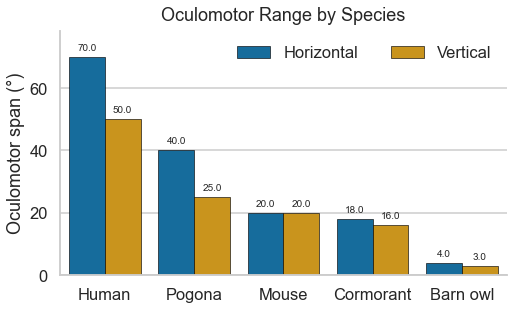

In [8]:
export_path = rf'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\span_different_animals'
spans = {
    "Human": {"horizontal_span": 70.0, "vertical_span": 50.0},
    "Barn owl": {"horizontal_span": 4.0, "vertical_span": 3.0},
    "Cormorant": {"horizontal_span": 18.0, "vertical_span": 16.0},
    "Mouse": {"horizontal_span":20, "vertical_span": 20},
    "Pogona": {"horizontal_span": 40.0, "vertical_span": 25.0},
}

fig, ax, df = plot_oculomotor_span_bars(
    spans,
    sort_by="mean",
    title="Oculomotor Range by Species",
    export_path=export_path,   # saves figures/oculomotor_span_bars.png and .pdf
)
plt.show()
